In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# TARGET DISTRIBUTION
mu1, sigma1 = 0, np.sqrt(2.5)
mu2, sigma2 = 10, np.sqrt(2.5)
eta = 0.3

def k(x):
    """Kernel of the mixture distribution."""
    return eta * np.exp(-0.5 * (x - mu1)**2 / sigma1**2) + (1 - eta) * np.exp(-0.5 * (x - mu2)**2 / sigma2**2)

# PROPOSAL DENSITY AND SAMPLE FROM PROPOSAL
sigma3 = 8

# Proposal PDF function
def proposal_pdf(x, mu):
    return norm.pdf(x, mu, sigma3)

# Function to sample from the proposal distribution
def sample_from_proposal(mu):
    return mu + sigma3 * np.random.randn()

In [3]:
# SET UP METROPOLIS HASTINGS 

# Parameters
M = 100000  # Number of samples (iterations)
burn = 10000  # Number of runs until the chain approaches stationarity
Mb = M + burn
nn = 100  # Number of samples for examining the AC

# Storage
xdraws = np.zeros(Mb)  # Samples drawn from the Markov chain (States)
accept = np.zeros(Mb)  # Accepted draws





In [4]:
# MAIN METROPOLIS HASTINGS ALGORITHM

# Initial state
x = 0            # Starting point of the chain
xdraws[0] = x
accept[0] = 1

for iter in range(Mb - 1):
    x = xdraws[iter]

    # Draw y from proposal density
    y = sample_from_proposal(x)

    # Compute acceptance probability
    # alpha = min((k(y) * proposal_pdf(x, y)) / (k(x) * proposal_pdf(y, x)), 1)
    alpha = min(k(y) / k(x), 1)  # In case of symmetric random walk the expression simplifies

    if np.random.rand() <= alpha:
        # Accept the draw
        xdraws[iter + 1] = y
        accept[iter + 1] = 1
    else:
        # Reject the draw
        xdraws[iter + 1] = x

# Drop burn-in samples
xdraws = xdraws[burn:]
accept = accept[burn:]
accept_rate = np.sum(accept) / M

# Display the acceptance rate
print('Acceptance rate:',accept_rate)

Acceptance rate: 0.33123


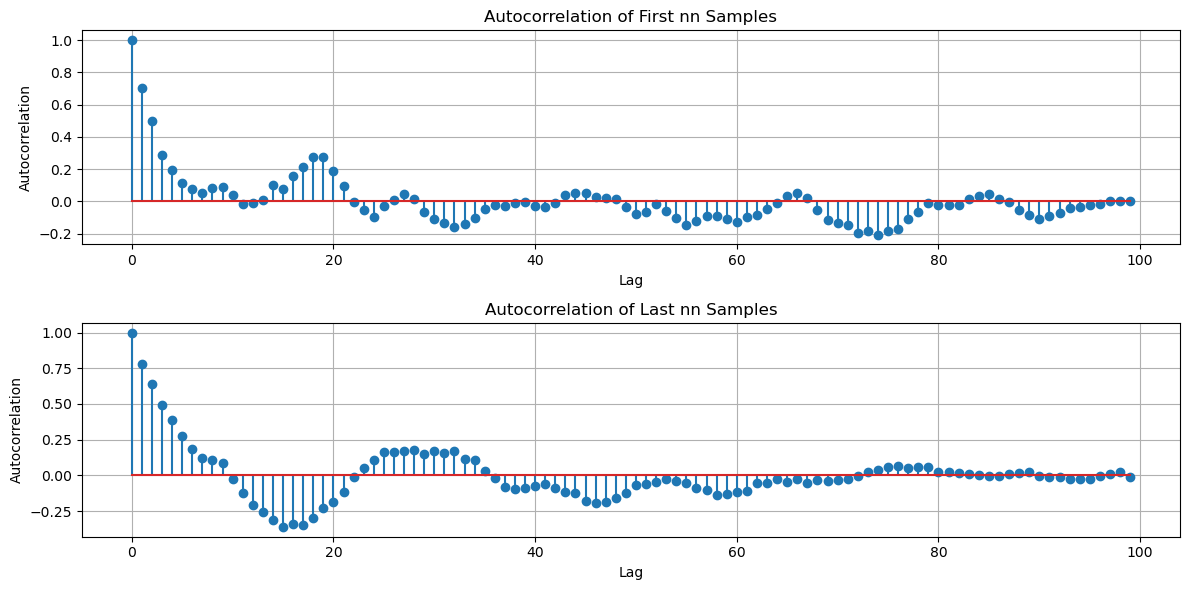

In [5]:
# COMPUTE AND PLOT AUTOCORRELATION OF THE CHAIN AT THE BEGINNING AND END OF THE SAMPLE

# Number of samples for examining the AC
nn = 100

# Compute autocorrelation of chain at beginning and end of sample
pp = xdraws[:nn]  # First nn samples
pp2 = xdraws[-nn:]  # Last nn samples

# Function to compute normalized autocorrelation
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    max_corr = result[result.size // 2]
    return result[result.size // 2:] / max_corr

# Compute autocorrelation
r = autocorrelation(pp - np.mean(pp))
r2 = autocorrelation(pp2 - np.mean(pp2))

# Lags for plotting
lags = np.arange(len(r))
lags2 = np.arange(len(r2))

# Plot the autocorrelation
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.stem(lags, r)
plt.grid(True)
plt.title('Autocorrelation of First nn Samples')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.subplot(2, 1, 2)
plt.stem(lags2, r2)
plt.grid(True)
plt.title('Autocorrelation of Last nn Samples')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.tight_layout()

# Export figure
filename = 'Figure_RWMH_Autocorrelations.pdf'
plt.savefig(filename)

plt.show()


In [6]:
# TEST FOR CONVERGENCE
# Geweke test 1992
# After removing burn in period, split the sample in two blocks:
# Block 1: first 10% of the sample
# Block 2: last 50% of the sample
# Check mean in block 1 and block 2. If they are approximately equal, the
# test is OK. If not, it has not converged yet
# Define blocks and compute means

block1 = xdraws[:round(0.1 * M)]
mean1 = np.mean(block1)

block2 = xdraws[round(0.5 * M):]
mean2 = np.mean(block2)

# Perform Geweke test
if np.abs((mean1 - mean2) / mean1) < 0.03:   # 3% error
    print('\nGeweke test: OK\n')
else:
    print('\nGeweke test: failed\n')



Geweke test: OK



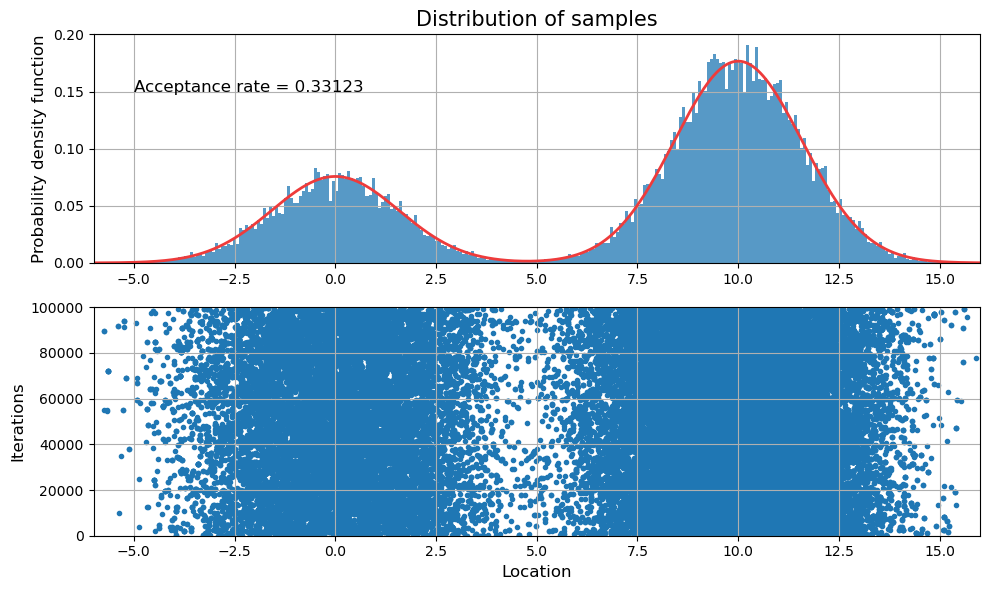

In [7]:
# MAKE PLOTS

# Colors
colors = {
    "color1": [0, 0.4470, 0.7410],
    "color2": [0.8500, 0.3250, 0.0980],
    "color3": [0.9290, 0.6940, 0.1250],
    "color4": [0.4940, 0.1840, 0.5560],
    "color5": [0.4660, 0.6740, 0.1880],
    "color6": [0.3010, 0.7450, 0.9330],
    "color7": [0.6350, 0.0780, 0.1840],
    "color8": [238/255, 59/255, 59/255]  # brown2 #ee3b3b
}


# Define x-axis values
xlow, xhig = -6, 16
xx = np.arange(xlow, xhig, 0.01)  # x-axis for plotting k(xx)

# Create figure
plt.figure(figsize=(10, 6))

# Subplot 1: Distribution of samples and normalized PDF
plt.subplot(2, 1, 1)
plt.hist(xdraws, bins=int(np.ceil(np.sqrt(M))), density=True, alpha=0.75)
plt.plot(xx, k(xx) / np.trapz(k(xx), xx), color=colors["color8"], linewidth=2)  # Normalized PDF
plt.xlim([xlow, xhig])
plt.grid(True)
plt.title('Distribution of samples', fontsize=15)
plt.ylabel('Probability density function', fontsize=12)
plt.text(xlow + 1, 0.15, f'Acceptance rate = {accept_rate}', fontsize=12)

# Subplot 2: Scatter plot of samples against iterations
plt.subplot(2, 1, 2)
plt.scatter(xdraws, np.arange(1, M + 1), marker='.')
plt.xlim([xlow, xhig])
plt.ylim([0, M])
plt.grid(True)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Iterations', fontsize=12)

plt.tight_layout()


# Export figure
filename = 'Figure_RWMH_Sampling.pdf'
plt.savefig(filename)

plt.show()

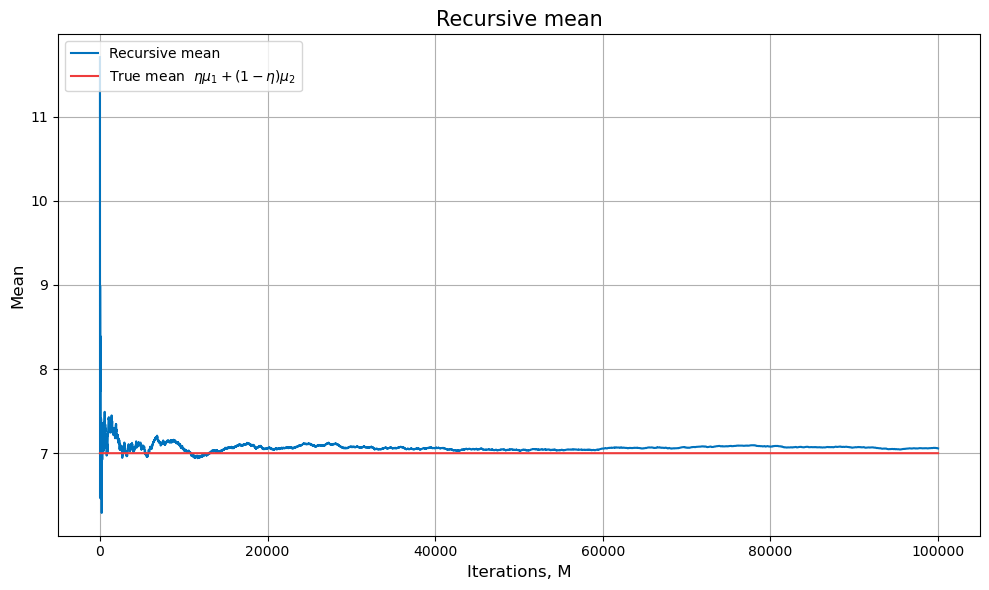

In [8]:
# COMPUTE AND PLOT RUNNING MEAN
# Compute cumulative sum and running mean
cumsum_xdraws = np.cumsum(xdraws)
indices = np.arange(1, M + 1)
running_mean = cumsum_xdraws / indices

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(indices, running_mean, color=colors["color1"], linewidth=1.5, label='Recursive mean')
plt.plot(indices, np.ones(M) * (eta * mu1 + (1 - eta) * mu2), color=colors["color8"], linewidth=1.5,
         label=r'True mean  $\eta \mu_1 + (1-\eta)\mu_2$')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Recursive mean', fontsize=15)
plt.xlabel('Iterations, M', fontsize=12)
plt.ylabel('Mean', fontsize=12)
plt.tight_layout()

# Export figure
filename = 'Figure_RWMH_RunningMean.pdf'
plt.savefig(filename)

plt.show()
